In [ ]:
import pandas as pd
import numpy as np

# Image processing
from PIL import Image
from io import BytesIO

# Data splitting
from sklearn.model_selection import train_test_split


df = pd.read_csv('/content/tag_clean_10_6.csv')
df.head()

,filename,tag
0,45rpm#1.png,3
1,45rpm#10.png,3
2,45rpm#100.png,2
3,45rpm#101.png,2
4,45rpm#102.png,3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import pandas as pd
import numpy as np
import os

# Initialize empty lists to store images and labels
loaded_images = []
loaded_labels = []

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/tag_clean_10_6.csv')

# Create a dictionary for filename-label mapping
filename_label_mapping = dict(zip(df['filename'], df['tag']))

# Specify the folder where the preprocessed images are saved
save_folder = '/content/drive/MyDrive/Colab Notebooks/preprocessed_images/'

# Loop through the saved images and load them into memory
for filename in os.listdir(save_folder):
    if filename.endswith(".png"):  # Add more conditions if you have multiple file types
        img_path = os.path.join(save_folder, filename)

        # Open and read the image
        image_data = Image.open(img_path)

        # Convert the image to a numpy array and normalize it
        image_data = np.array(image_data) / 255.0

        # Append the image data to the list
        loaded_images.append(image_data)

        # Use filename to get the corresponding label from the mapping
        label = filename_label_mapping.get(filename, None)
        if label is not None:
            loaded_labels.append(label)

# Convert lists to numpy arrays
images = np.array(loaded_images)
labels = np.array(loaded_labels)



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

In [ ]:
print("Distribution of classes in y_train:", np.bincount(y_train))


Distribution of classes in y_train: [  0 155 167 599]


In [ ]:
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

print("Distribution of classes in y_train:", np.bincount(y_train))

Distribution of classes in y_train: [155 167 599]


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

# Load the VGG16 network with its pre-trained weights, but without its classifier
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze all layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create the model with additional layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1024),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 1024)             

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint


# Define the path where you want to save the model
save_path = '/content/drive/MyDrive/Colab Notebooks/my_model.h5'

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/best_model.h5',
                                   monitor='val_accuracy',
                                   mode='max',
                                   save_best_only=True,
                                   verbose=1)


history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint])  # Add callbacks here


# Save the model to Google Drive
model.save(save_path)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 1.1038 - accuracy: 0.4875
Epoch 1: val_accuracy improved from -inf to 0.70033, saving model to /content/drive/MyDrive/Colab Notebooks/best_model.h5
29/29 [==============================] - 18s 489ms/step - loss: 1.1038 - accuracy: 0.4875 - val_loss: 0.9519 - val_accuracy: 0.7003
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.9899 - accuracy: 0.5852
Epoch 2: val_accuracy did not improve from 0.70033
29/29 [==============================] - 13s 441ms/step - loss: 0.9899 - accuracy: 0.5852 - val_loss: 0.9523 - val_accuracy: 0.6971
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.9633 - accuracy: 0.6156
Epoch 3: val_accuracy did not improve from 0.70033
29/29 [==============================] - 13s 436ms/step - loss: 0.9633 - accuracy: 0.6156 - val_loss: 0.9120 - val_accuracy: 0.7003
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 0.9475 - accuracy: 0.6091


In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model_path = '/content/drive/MyDrive/Colab Notebooks/best_model.h5'
model = load_model(best_model_path)

# Continue training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,  # specify the number of additional epochs
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint])


Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.7481
Epoch 1: val_accuracy did not improve from 0.79805
29/29 [==============================] - 16s 446ms/step - loss: 0.5774 - accuracy: 0.7481 - val_loss: 0.5182 - val_accuracy: 0.7850
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7524
Epoch 2: val_accuracy did not improve from 0.79805
29/29 [==============================] - 13s 433ms/step - loss: 0.5999 - accuracy: 0.7524 - val_loss: 0.5259 - val_accuracy: 0.7850
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.7655
Epoch 3: val_accuracy did not improve from 0.79805
29/29 [==============================] - 13s 430ms/step - loss: 0.5782 - accuracy: 0.7655 - val_loss: 0.5089 - val_accuracy: 0.7948
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.7622
Epoch 4: val_accuracy did not improve from 0.79805
29/29 [=============

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model_path = '/content/drive/MyDrive/Colab Notebooks/best_model.h5'
model = load_model(best_model_path)

# Continue training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=100,  # specify the number of additional epochs
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint])


Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7959
Epoch 1: val_accuracy did not improve from 0.81433
29/29 [==============================] - 16s 435ms/step - loss: 0.5085 - accuracy: 0.7959 - val_loss: 0.5159 - val_accuracy: 0.8111
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 0.5278 - accuracy: 0.7970
Epoch 2: val_accuracy did not improve from 0.81433
29/29 [==============================] - 13s 430ms/step - loss: 0.5278 - accuracy: 0.7970 - val_loss: 0.5458 - val_accuracy: 0.7948
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.7980
Epoch 3: val_accuracy did not improve from 0.81433
29/29 [==============================] - 13s 432ms/step - loss: 0.4933 - accuracy: 0.7980 - val_loss: 0.5487 - val_accuracy: 0.7915
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 0.5184 - accuracy: 0.7861
Epoch 4: val_accuracy did not improve from 0.81433
29/29 [=============

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model_path = '/content/drive/MyDrive/Colab Notebooks/best_model.h5'
model = load_model(best_model_path)

# Continue training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=50,  # specify the number of additional epochs
                    validation_data=(X_val, y_val),
                    callbacks=[model_checkpoint])


Epoch 1/50
29/29 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.7850
Epoch 1: val_accuracy did not improve from 0.82736
29/29 [==============================] - 16s 433ms/step - loss: 0.5224 - accuracy: 0.7850 - val_loss: 0.4570 - val_accuracy: 0.8274
Epoch 2/50
29/29 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.7937
Epoch 2: val_accuracy did not improve from 0.82736
29/29 [==============================] - 12s 417ms/step - loss: 0.5161 - accuracy: 0.7937 - val_loss: 0.4726 - val_accuracy: 0.8208
Epoch 3/50
29/29 [==============================] - ETA: 0s - loss: 0.5173 - accuracy: 0.8111
Epoch 3: val_accuracy did not improve from 0.82736
29/29 [==============================] - 12s 416ms/step - loss: 0.5173 - accuracy: 0.8111 - val_loss: 0.4894 - val_accuracy: 0.8013
Epoch 4/50
29/29 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.8002
Epoch 4: val_accuracy did not improve from 0.82736
29/29 [=================

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_model_path = '/content/drive/MyDrive/Colab Notebooks/best_model.h5'
best_model = load_model(best_model_path)


In [ ]:
best_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 1024)             

In [ ]:
# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


10/10 [==============================] - 243s 24s/step - loss: 0.4074 - accuracy: 0.8474
Test Loss: 0.4074183702468872
Test Accuracy: 0.8474025726318359


10/10 [==============================] - 258s 25s/step


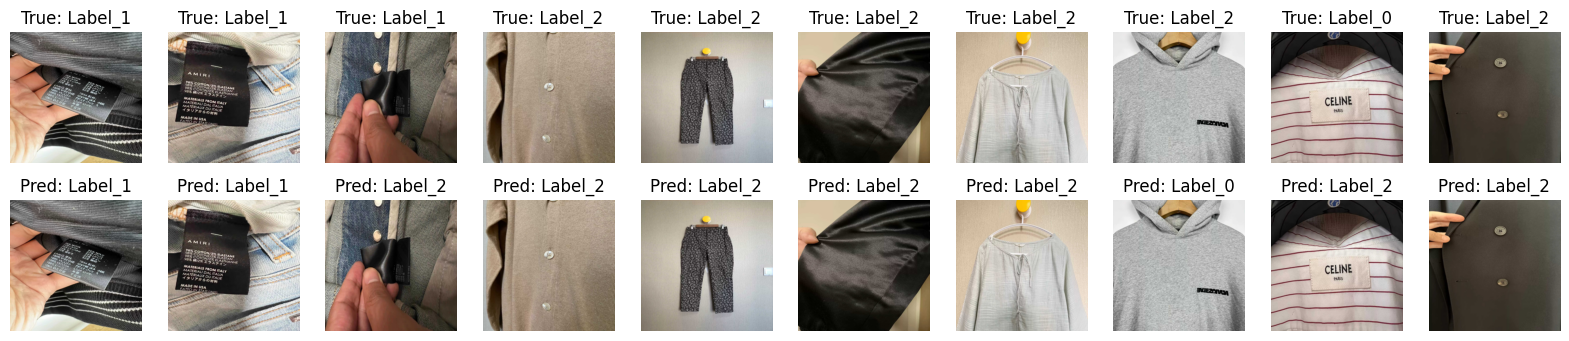

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Make predictions on the test set
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Define label names (modify this according to your specific labels)
label_names = {0: 'Label_0', 1: 'Label_1', 2: 'Label_2'}

# Plot images with their predicted labels
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow((X_test[i] * 255).astype(np.uint8))
    plt.title("True: " + label_names[y_test[i]])
    plt.axis('off')

    # Display predictions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow((X_test[i] * 255).astype(np.uint8))
    plt.title("Pred: " + label_names[y_pred_classes[i]])
    plt.axis('off')

plt.show()


In [ ]:
 y_pred_classes

array([1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 0, 1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 2, 1, 2, 1, 0,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 1,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2,
       0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2,

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix



# Generate a confusion matrix
conf_mtx = confusion_matrix(y_test, y_pred_classes)

# Generate a classification report
class_report = classification_report(y_test, y_pred_classes)

print("Confusion Matrix:")
print(conf_mtx)


Confusion Matrix:
[[ 26   2  18]
 [  4  42   7]
 [  6  10 193]]


In [ ]:

print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.57      0.63        46
           1       0.78      0.79      0.79        53
           2       0.89      0.92      0.90       209

    accuracy                           0.85       308
   macro avg       0.80      0.76      0.77       308
weighted avg       0.84      0.85      0.84       308



In [ ]:
len(labels)

1536